# Part III: Generative Adversarial Networks

## Workshop em Deep Learning


```
	
	@author: Rafa Felix <rafael.felixalves@adelaide.edu.au>
	Australian Centre for Robotic Vision (ACRV)
	School of Computer Science
	The University of Adelaide
	
	References:
  [1]
	

```

---

### Instituto Federal de Minas Gerais


# Verificando versão do Python

In [1]:
import sys
sys.version

'3.6.3 (default, Oct  3 2017, 21:45:48) \n[GCC 7.2.0]'

In [2]:
# pip3: assistente de pacotes do python 3.
# pytorch: framework para desenvolvimento de algoritmos Deep Learning;

# instalação do pytorch
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

#torchvision: framework do pytorch com banco de dados e modelos de deep learning
#             que já são considerados estáveis pela comunidade científica.

# instalação do torchvision
!pip3 install torchvision


# Importando e verificando Pytorch e TorchVision

In [0]:
import torch #importando torch
import torch.nn as nn # importando pacote de neural networks nn

# importando pacote de datasets, a este atribuimos o alias dsets
import torchvision.datasets as dsets 

# importando pacote de data augmentation
import torchvision.transforms as transforms 

# importando pacote de grafos e gradientes
from torch.autograd import Variable

In [0]:
%matplotlib inline

In [0]:
# importando pacote time
import time
import itertools
import math
from IPython import display

import matplotlib.pyplot as plt


In [0]:
input_size    = 784   # The image size = 28 x 28 = 784
num_classes   = 10    # The number of output classes. In this case, from 0 to 9
num_epochs    = 5     # The number of times entire dataset is trained
batch_size    = 100   # The size of input data took for one iteration
learning_rate = 2e-4  # The speed of convergence

# use_cuda é um parametro que utilizamos em nosso código para
# definir onde utilizaremos a GPU ou não. Como estamos utilizando o Google Colab
# podemos utilizar use_cuda como True. Caso você tente executar em uma outra
# plataforma que não possua GPU, utilize está flag como False.
use_cuda = True

# Dataset

In [0]:
# dsets é o alias que atribuimos ao pacote torchvision.datasets

# MNIST consiste em um dataset de caracteres.
# Normalmente o MNIST é o dataset mais utilizado educacionalmente
# em visão computacional;
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [0]:

# Para treino, utilizamos a função shuffle = true
# Utilizamos a função shuffle para evitar overfitting
# e adicionar estocasticidade ao processo.

#train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                          batch_size=batch_size,
#                                          shuffle=True)

# Para test, utilizamos a função shuffle = false
#test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                          batch_size=batch_size,
#                                          shuffle=False)

In [0]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = dsets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

## Visualizando exemplares do MNIST



torch.Size([60000, 28, 28])
torch.Size([60000])


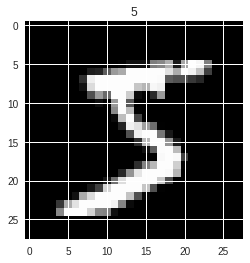

In [10]:
# Informacoes do dataset

# dimensoes
print(train_loader.dataset.train_data.size())                 # (60000, 28, 28)

# classes
print(train_loader.dataset.train_labels.size())               # (60000)

# plotting digito
plt.imshow(train_loader.dataset.train_data[0].numpy(),  # mudar o numero dentro para exibir outros exemplares
           cmap='gray')
plt.title('%i' % train_loader.dataset.train_labels[0])
plt.show()

#Implementacao

## Modelo

In [0]:

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [13]:
discriminator = Discriminator()
generator = Generator()

print(discriminator)
print(generator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024)
    (1): LeakyReLU(0.2, inplace)
    (2): Dropout(p=0.3)
    (3): Linear(in_features=1024, out_features=512)
    (4): LeakyReLU(0.2, inplace)
    (5): Dropout(p=0.3)
    (6): Linear(in_features=512, out_features=256)
    (7): LeakyReLU(0.2, inplace)
    (8): Dropout(p=0.3)
    (9): Linear(in_features=256, out_features=1)
    (10): Sigmoid()
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256)
    (1): LeakyReLU(0.2, inplace)
    (2): Linear(in_features=256, out_features=512)
    (3): LeakyReLU(0.2, inplace)
    (4): Linear(in_features=512, out_features=1024)
    (5): LeakyReLU(0.2, inplace)
    (6): Linear(in_features=1024, out_features=784)
    (7): Tanh()
  )
)


In [0]:
if use_cuda and torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

## Optimizer e Funcao Objetivo

In [0]:
criterion = nn.BCELoss()

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)

# Treinando a Rede

In [0]:

def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [0]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [0]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100).cuda())

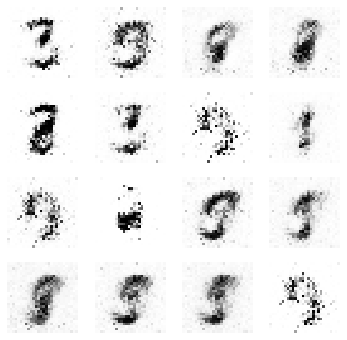

Epoch [6/200], Step[600/600], d_loss: 0.5873, g_loss: 2.2456, D(x): 0.86, D(G(z)): 0.27


In [0]:

# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 200
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = Variable(images.cuda())
        real_labels = Variable(torch.ones(images.size(0)).cuda())
        
        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100).cuda())
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)).cuda())
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100).cuda())
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            #plt.savefig('results/mnist-gan-%03d.png'%num_fig)
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))

fig.close()